In [1]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [2]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [88]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):    
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def voigt(f, f_0, a, sigma, gamma, c):
    return voigt_profile(f - f_0, sigma, gamma) * a + c

def get_voigt_fit(detunings, voltages):    
    fitter = Fitter(voigt)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"a": -0.1, "sigma": 0.5, "gamma": 0., "c": 0.9})
    fitter.fit()
    
    return fitter

def linear(x, a, b):
    return a*x + b

def get_linear_fit(amplitudes, heights):
    fitter = Fitter(linear)
    fitter.set_absolute_sigma(False)
    fitter.set_data(amplitudes, heights)
    fitter.fit()

    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c
    

In [89]:
def rf_spectroscopy(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset_2"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    offsets = np.array(offsets)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = offsets
    ys = 1 - ratios
    return xs, ys
    

In [90]:
def rf_spectroscopy_field(data_list):
    positive_antihole_heights = []
    positive_antihole_height_errs = []
    negative_antihole_heights = []
    negative_antihole_height_errs = []
    positive_rf_heights = []
    positive_rf_height_errs = []
    negative_rf_heights = []
    negative_rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset_2"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        positive_mask = detunings > 0
        positive_antihole_fit = get_gaussian_fit(detunings[positive_mask], antihole_avg[positive_mask]/chasm_avg[positive_mask])
        positive_antihole_heights.append(positive_antihole_fit.results["a"])
        positive_antihole_height_errs.append(positive_antihole_fit.errors["a"])
        
        positive_rf_fit = get_gaussian_fit(detunings[positive_mask], rf_avg[positive_mask]/chasm_avg[positive_mask])
        positive_rf_heights.append(positive_rf_fit.results["a"])
        positive_rf_height_errs.append(positive_rf_fit.errors["a"])
    
        negative_mask = detunings < 0
        negative_antihole_fit = get_gaussian_fit(detunings[negative_mask], antihole_avg[negative_mask]/chasm_avg[negative_mask])
        negative_antihole_heights.append(negative_antihole_fit.results["a"])
        negative_antihole_height_errs.append(negative_antihole_fit.errors["a"])
        
        negative_rf_fit = get_gaussian_fit(detunings[negative_mask], rf_avg[negative_mask]/chasm_avg[negative_mask])
        negative_rf_heights.append(negative_rf_fit.results["a"])
        negative_rf_height_errs.append(negative_rf_fit.errors["a"])

    offsets = np.array(offsets)
    positive_antihole_heights = np.array(positive_antihole_heights)
    positive_antihole_height_errs = np.array(positive_antihole_height_errs)
    negative_antihole_heights = np.array(negative_antihole_heights)
    negative_antihole_height_errs = np.array(negative_antihole_height_errs)
    positive_rf_heights = np.array(positive_rf_heights)
    positive_rf_height_errs = np.array(positive_rf_height_errs)
    negative_rf_heights = np.array(negative_rf_heights)
    negative_rf_height_errs = np.array(negative_rf_height_errs)
    positive_ratios = positive_rf_heights / positive_antihole_heights
    positive_ratio_errs = positive_ratios * np.sqrt((positive_rf_height_errs / positive_rf_heights) ** 2 + (positive_antihole_height_errs / positive_antihole_heights) ** 2)
    negative_ratios = negative_rf_heights / negative_antihole_heights
    negative_ratio_errs = negative_ratios * np.sqrt((negative_rf_height_errs / negative_rf_heights) ** 2 + (negative_antihole_height_errs / negative_antihole_heights) ** 2)

    xs = offsets
    positive_ys = 1 - positive_ratios
    negative_ys = 1 - negative_ratios
    return xs, positive_ys, negative_ys
    

In [91]:
def rf_flopping(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    times = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        times.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    times = np.array(times)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = times
    ys = 1 - ratios
    return xs, ys
    

In [92]:
def temporal_drift(data_list):
    chasm_voltages = []
    antihole_offsets = []
    antihole_amplitudes = []
    antihole_f0s = []
    antihole_slopes = []
    antihole_gammas = []
    rf_offsets = []
    rf_amplitudes = []
    rf_f0s = []
    rf_slopes = []
    rf_gammas = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        chasm_voltages.append(np.average(chasm_avg))
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_amplitudes.append(antihole_fit.results["a"])
        #antihole_slopes.append(antihole_fit.results["b"])
        antihole_offsets.append(antihole_fit.results["c"])
        antihole_gammas.append(antihole_fit.results["sigma"])
        antihole_f0s.append(antihole_fit.results["f_0"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_amplitudes.append(rf_fit.results["a"])
        #rf_slopes.append(rf_fit.results["b"])
        rf_offsets.append(rf_fit.results["c"])
        rf_gammas.append(rf_fit.results["sigma"])
        rf_f0s.append(rf_fit.results["f_0"])

    return (
        np.array(chasm_voltages),
        np.array(antihole_offsets),
        np.array(antihole_amplitudes),
        np.array(antihole_f0s),
        np.array(antihole_slopes),
        np.array(antihole_gammas),
        np.array(rf_offsets),
        np.array(rf_amplitudes),
        np.array(rf_f0s),
        np.array(rf_slopes),
        np.array(rf_gammas),
    )

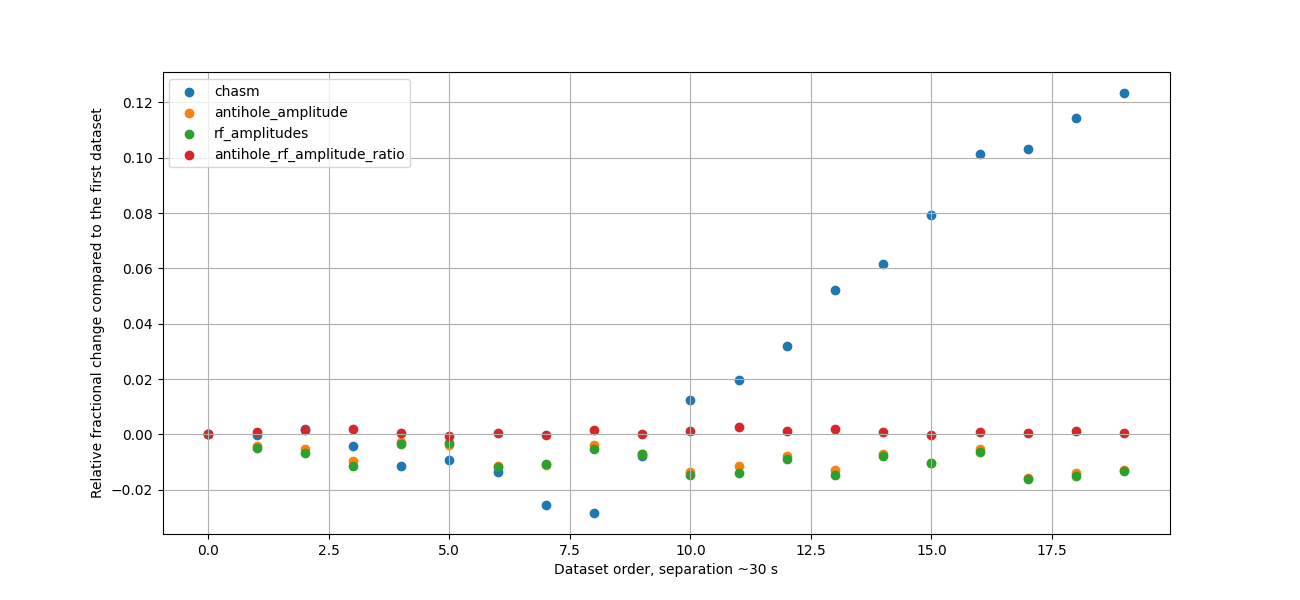

In [93]:
#dnums = list(range(12535, 12573))
dnums = list(range(12768, 12788))
dnums_plt = np.array(dnums) - dnums[0]
chasm_voltages, antihole_offsets, antihole_amplitudes, antihole_f0s, antihole_slopes, antihole_gammas, rf_offsets, rf_amplitudes, rf_f0s, rf_slopes, rf_gammas = temporal_drift(dnums)

fig, ax = plt.subplots(figsize=(13, 6))
ax.scatter(dnums_plt, chasm_voltages / chasm_voltages[0] - 1, label="chasm")
#ax.scatter(dnums_plt, antihole_offsets / antihole_offsets[0], label="antihole_offset")
ax.scatter(dnums_plt, antihole_amplitudes / antihole_amplitudes[0] - 1, label="antihole_amplitude")
#ax.scatter(dnums_plt, rf_offsets / rf_offsets[0], label="rf_offset")
ax.scatter(dnums_plt, rf_amplitudes / rf_amplitudes[0] - 1, label="rf_amplitudes")
ax.scatter(dnums_plt, antihole_amplitudes / rf_amplitudes / (antihole_amplitudes[0] / rf_amplitudes[0]) - 1, label="antihole_rf_amplitude_ratio")
#ax.scatter(dnums_plt, (antihole_gammas / rf_gammas / (antihole_gammas[0] / rf_gammas[0]) - 1), label="antihole_rf_gamma_ratio")

ax.set_xlabel("Dataset order, separation ~30 s")
ax.set_ylabel("Relative fractional change compared to the first dataset")
ax.legend()
ax.grid()
plt.show()

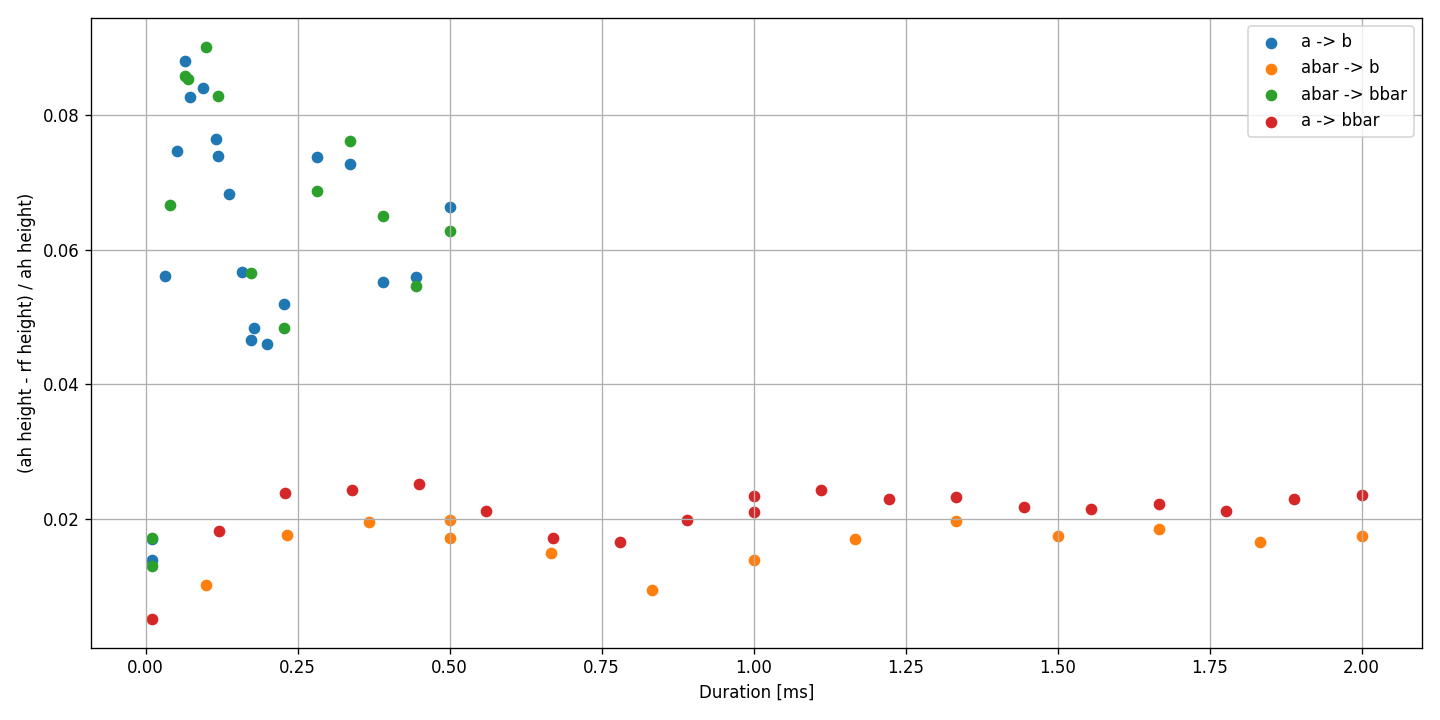

In [94]:
data = {
    "a -> b" : [7409, 7428],
    "abar -> b" : [7469, 7482],
    "abar -> bbar" : [7483, 7496],
    "a -> bbar" : [7497, 7516],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_flopping(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("Duration [ms]")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

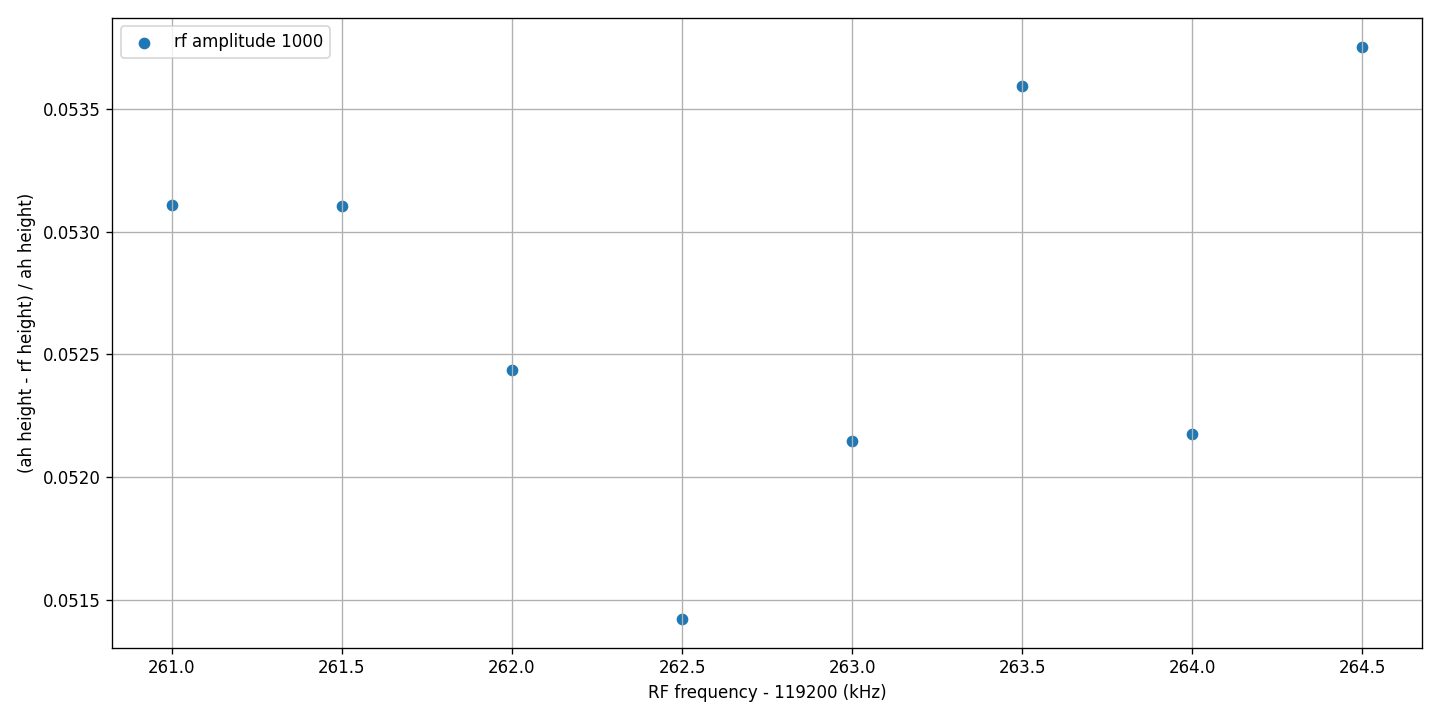

In [95]:
# data_list = range(3599, 3718)

data = {
    #"simultaneous prep, b->abar" : [5900, 5959],
    # "sequential prep, b->abar, 5 ms" : [6020, 6079],
    #"simultaneous prep, b->abar, confirm" : [6080, 6139],
    # "sequential prep, b->a, 5 ms" : [6153, 6212],
    # "sequential prep, b->a, 20 ms" : [6213, 6243],
    # "sequential prep, b->a, 4x more antihole repeats" : [6245, 6284],
    #"sequential prep, b->a, optimized" : [7190, 7229],
    #"sequential prep, b->abar, same time and power as above" : [7282, 7321],
    #"sequential prep, bbar->abar, same time and power as above" : [7322, 7361],
    #"sequential prep, bbar->abar, same time and power as above" : [7459, 7468],
    "rf amplitude 1000" : [12933, 12940],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spectroscopy(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

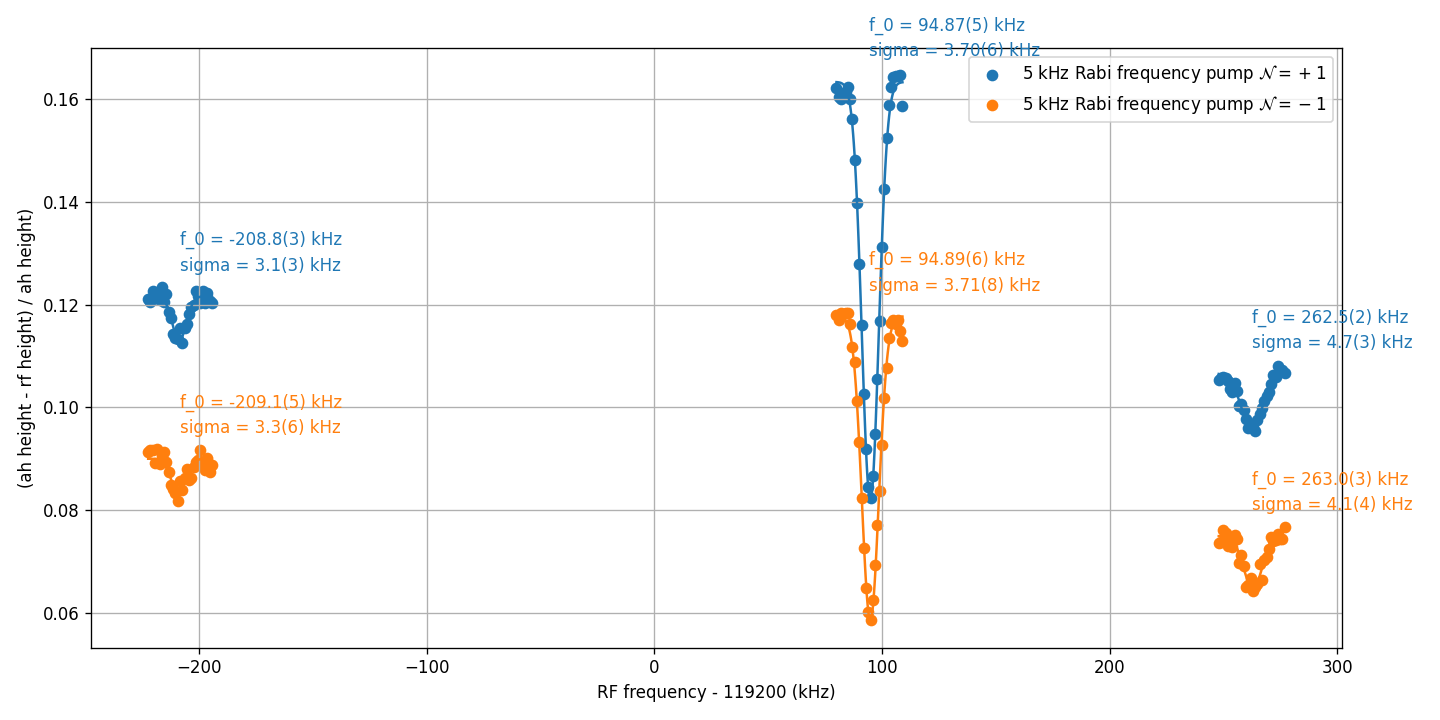

In [148]:
data = {
    "5 kHz Rabi frequency pump" : [13914, 14002],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)
    ax.scatter(xs, pos_ys, label = label + " $\\mathcal{N}=+1$")
    ax.scatter(xs, neg_ys, label = label + " $\\mathcal{N}=-1$")

    mask = xs < 0
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": -210})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": -210})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = abs(xs) < 150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": 95})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": 95})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = xs > 200
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": 263})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": 263})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(np.average(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(np.average(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")

ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("(ah height - rf height) / ah height)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [71]:
data, headers = get_experiment_data(13922)

In [72]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

/home/icarus/.venv/vlab/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


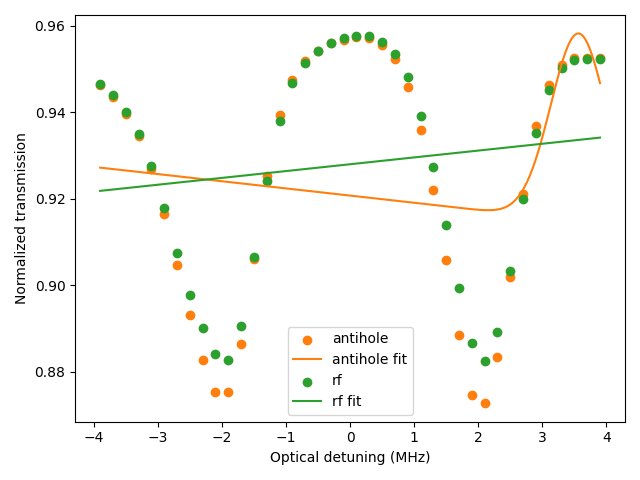

0.04339832537202701
0.02149876961550308
-0.43508719992434236
0.3557726864641811


In [73]:
plt_monitor = False

antihole_normalized = antihole_avg/chasm_avg
rf_normalized = rf_avg/chasm_avg

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")

antihole_fit = get_gaussian_fit(detunings_MHz, antihole_normalized)
xaxis = np.linspace(min(detunings_MHz), max(detunings_MHz), 1000)
ax.scatter(detunings_MHz, antihole_normalized, label="antihole", color="C1")
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    rf_fit = get_gaussian_fit(detunings_MHz, rf_normalized)
    ax.scatter(detunings_MHz, rf_normalized, label="rf", color="C2")
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.results["a"])
print(antihole_fit.errors["a"])
print(antihole_fit.results["sigma"])
print(antihole_fit.errors["sigma"])